In [1]:
import os
import cv2
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage import measure, color
from collections import defaultdict
from PIL import Image

plt.style.use('ggplot')
%matplotlib inline

os.chdir('../')

### Dataset Structure

In [56]:
DATA_ROOT = 'data/raw'
DATA_PROCESSED = 'data/processed'

In [3]:
for fold in ['test', 'train', 'val']:
    
    fold_path = os.path.join(DATA_ROOT, fold)
    images = os.path.join(fold_path, 'images')

    num_images = len(os.listdir(images)) if os.path.exists(images) else 0

    print(f'{fold.upper()}: {num_images}')

TEST: 724
TRAIN: 5063
VAL: 662


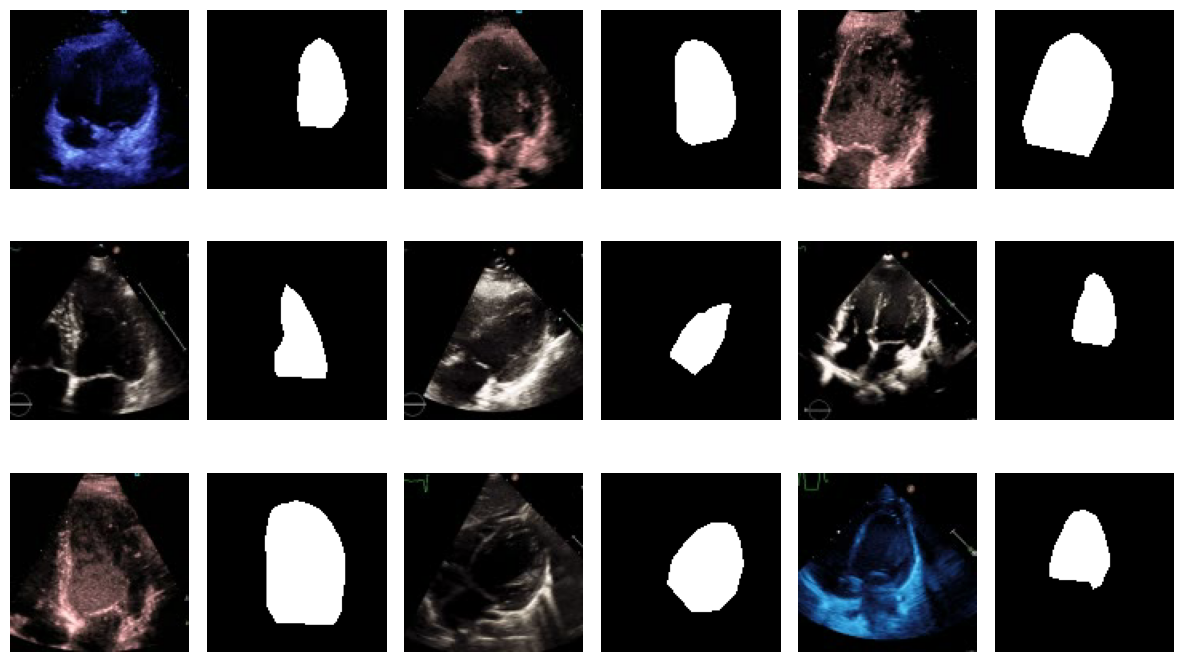

In [30]:
image_dir = os.path.join(DATA_ROOT, 'train/images')
mask_dir = os.path.join(DATA_ROOT, 'train/masks')
num_samples = 9

files = os.listdir(image_dir)
selected_files = random.sample(files, num_samples)

grid_size = math.ceil(math.sqrt(num_samples))

fig, axs = plt.subplots(grid_size, grid_size * 2, figsize=(grid_size * 4, grid_size * 2.5))

for i, file in enumerate(selected_files):
    img = Image.open(os.path.join(image_dir, file))
    mask = Image.open(os.path.join(mask_dir, file))
    
    row = i // grid_size
    col = (i % grid_size) * 2
    
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].axis('off')

    axs[row, col + 1].imshow(mask, cmap='gray')
    axs[row, col + 1].axis('off')

total_plots = grid_size * grid_size
for i in range(num_samples, total_plots):
    row = i // grid_size
    col = (i % grid_size) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

### LVs Area Distribution Analysis

In [5]:
areas_by_split = {}
splits = ['train', 'val', 'test']

for split in splits:
    mask_dir = os.path.join(DATA_ROOT, split, 'masks')
    if not os.path.exists(mask_dir):
        print(f'Mask directory for {split} not found')
        continue
    
    areas = {}
    for file in sorted(os.listdir(mask_dir)):
        path = os.path.join(mask_dir, file)
        try:
            mask = np.array(Image.open(path).convert("L"))
            binary_mask = mask > 0
            area = np.sum(binary_mask)
            areas[f"{file}"] = area
        except Exception as e:
            print(f"Error processing {file} in {split}: {e}")
    
    areas_by_split[split] = areas

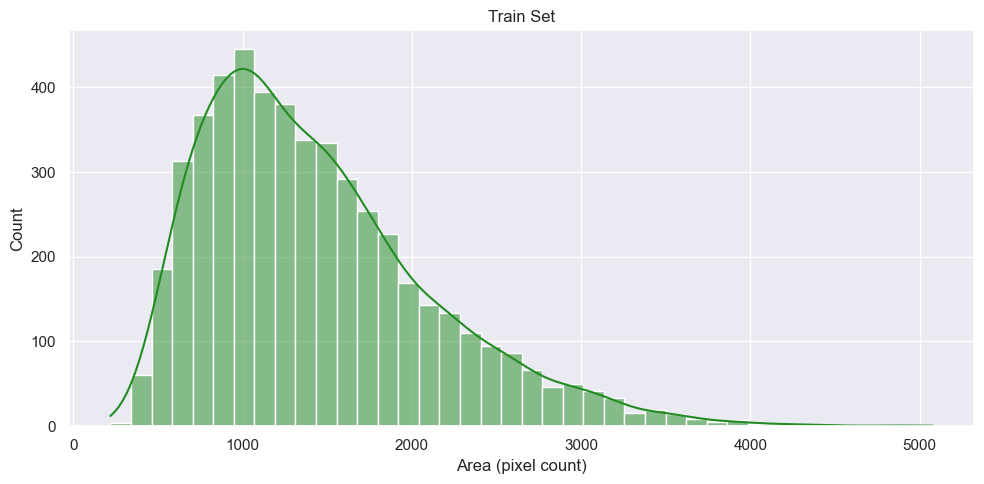

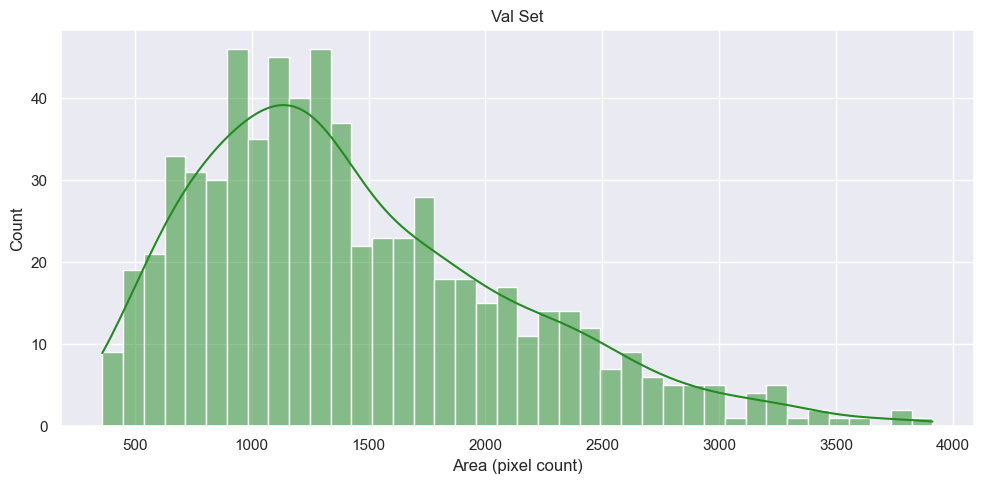

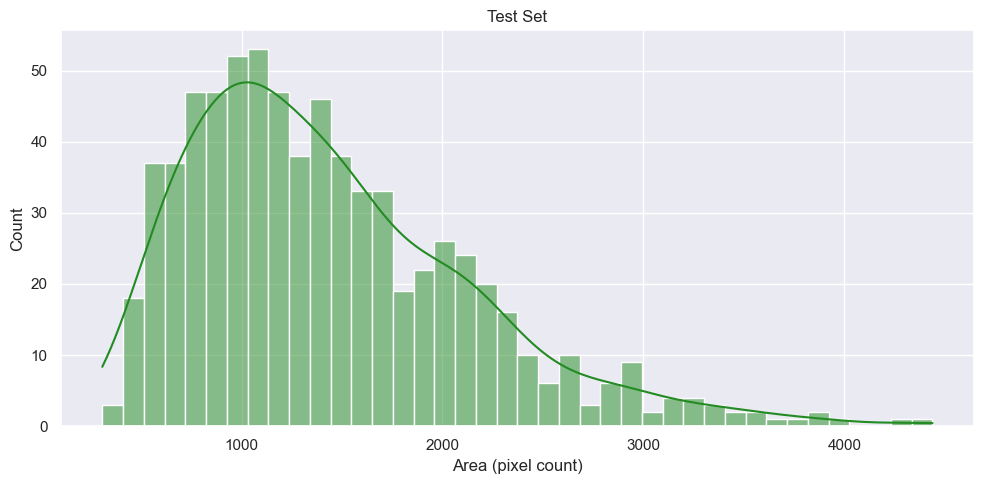

In [6]:
for split, areas_dict in areas_by_split.items():
    areas = list(areas_dict.values())
    plt.figure(figsize=(10, 5))
    sns.set(style='darkgrid')
    sns.histplot(areas, bins=40, color='forestgreen', kde=True)
    plt.title(f'{split.capitalize()} Set')
    plt.xlabel('Area (pixel count)')
    plt.tight_layout()
    plt.show()

In [42]:
def show_image_and_mask_pairs(split, filenames):
    n_images = len(filenames)
    if n_images == 0:
        print("No images to display.")
        return

    cols = min(n_images, 3)
    rows = int(np.ceil(n_images / cols))

    fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 6, rows * 3))
    axes = axes.flatten()

    for i, file in enumerate(filenames):

        mask_path = os.path.join(DATA_ROOT, split, 'masks', file)
        image_path = os.path.join(DATA_ROOT, split,  'images', file)

        try:
            mask = Image.open(mask_path).convert("L")
            image = Image.open(image_path).convert("L")


            axes[2*i].imshow(image, cmap='gray')
            axes[2*i].axis('off')

            axes[2*i+1].imshow(mask, cmap='gray')
            axes[2*i+1].axis('off')

        except Exception as e:
            print(f"Error loading {file}: {e}")
            axes[2*i].axis('off')
            axes[2*i+1].axis('off')

    for ax in axes[2*n_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

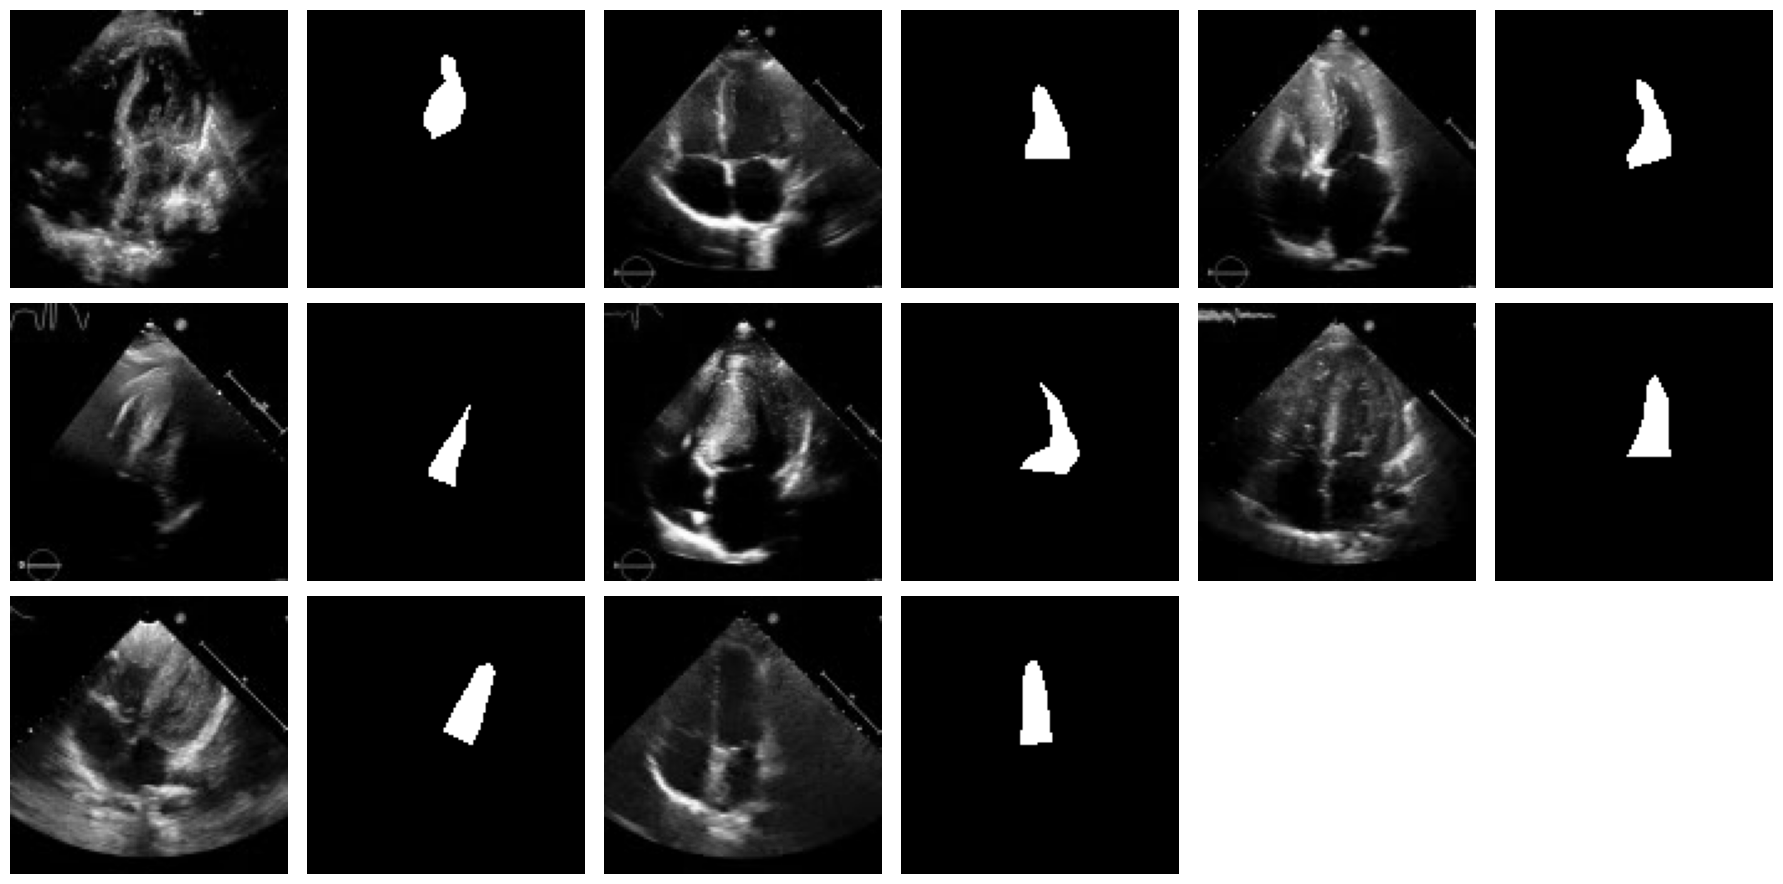

In [40]:
threshold = 350
fold = 'train'

area_bellow_threshold = [file for (file, area) in areas_by_split[fold].items() if area < threshold] 

show_image_and_mask_pairs(fold, area_bellow_threshold)


In [64]:
from scipy.ndimage import label

def n_components_masks(fold_):
    
    masks_with_multiple_components = []
    mask_dir = os.path.join(DATA_ROOT, fold_, 'masks')

    for file in sorted(os.listdir(mask_dir)):
        
        path = os.path.join(mask_dir, file)
        
        mask = np.array(Image.open(path).convert('L')) > 0
        _, num_features = label(mask)

        if num_features != 1:
            masks_with_multiple_components.append(file)

    show_image_and_mask_pairs(fold_, masks_with_multiple_components)
    return masks_with_multiple_components


### Discarded Images

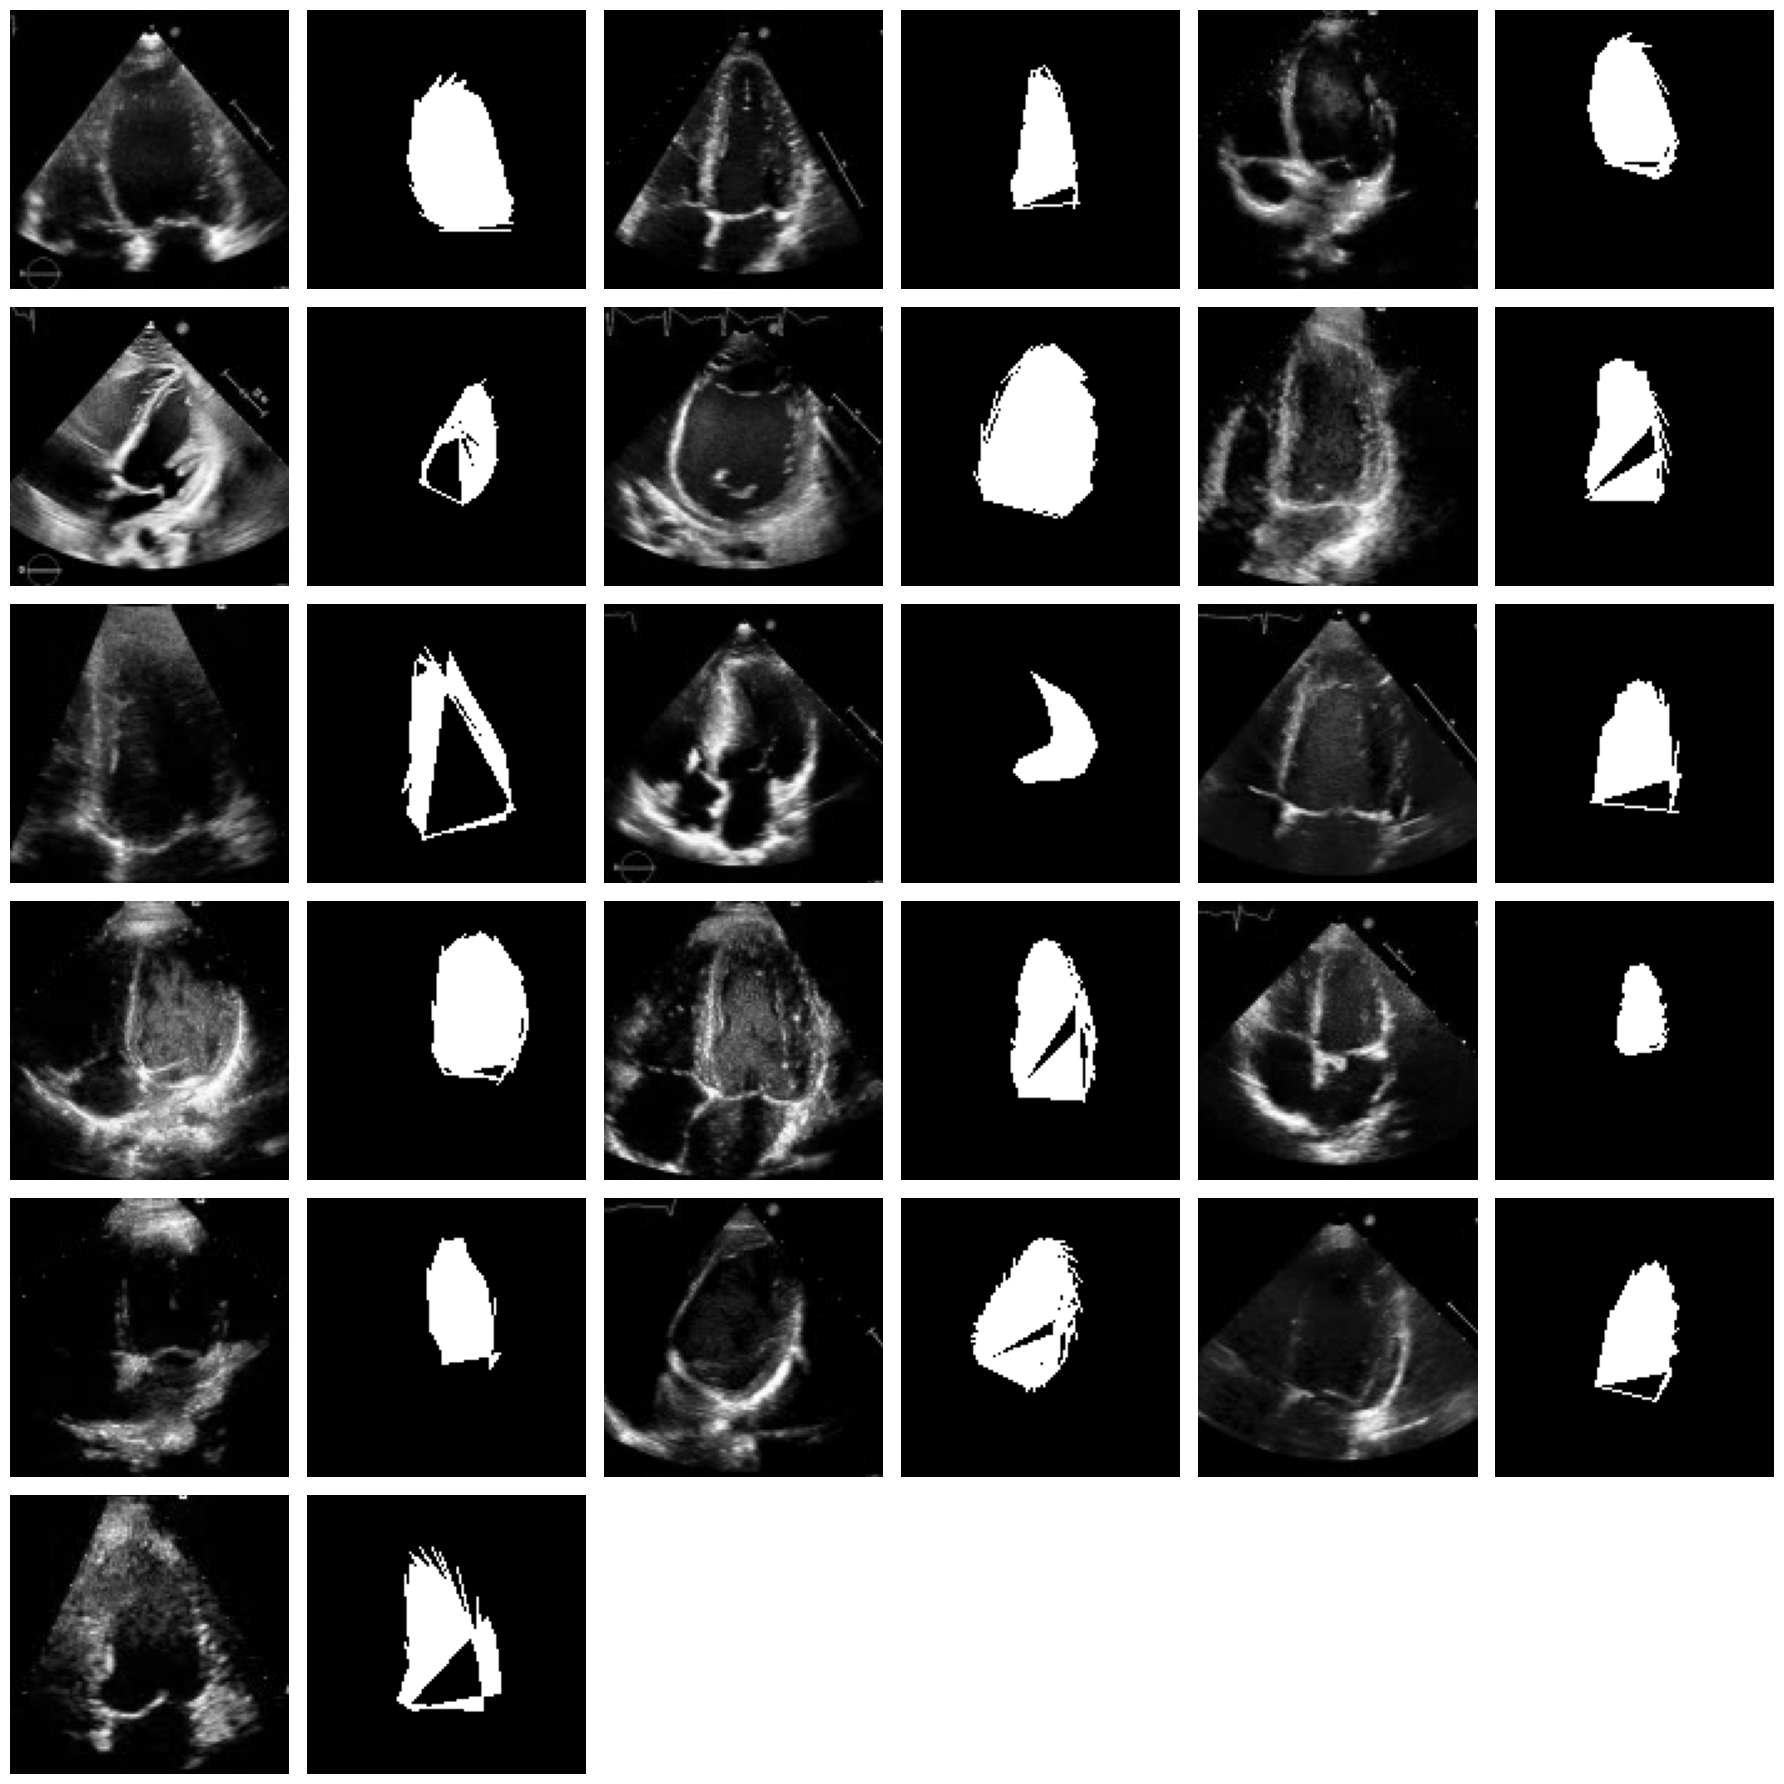

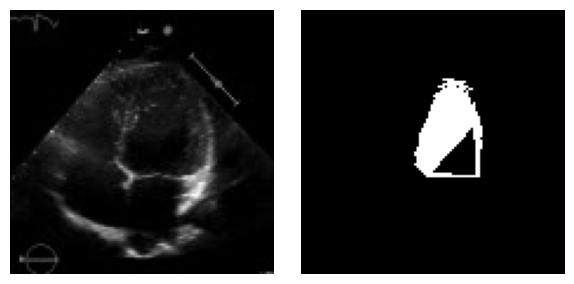

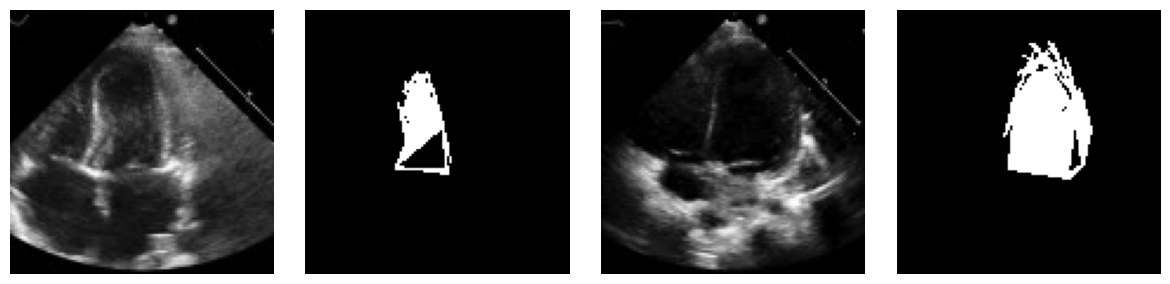

In [65]:
discarded = n_components_masks('train') + n_components_masks('val') + n_components_masks('test')  

In [59]:
import shutil

def move_valid_masks_and_images(fold):

    dst_mask_dir = os.path.join(DATA_PROCESSED, fold, 'masks')
    dst_img_dir = os.path.join(DATA_PROCESSED, fold, 'images')

    src_mask_dir = os.path.join(DATA_ROOT, fold, 'masks')
    src_img_dir = os.path.join(DATA_ROOT, fold, 'images')

    os.makedirs(dst_mask_dir, exist_ok=True)
    os.makedirs(dst_img_dir, exist_ok=True)

    for file in sorted(os.listdir(src_mask_dir)):

        if file not in discarded:

            mask_path = os.path.join(src_mask_dir, file)
            image_path = os.path.join(src_img_dir, file)

            shutil.copy(mask_path, os.path.join(dst_mask_dir, file))
            shutil.copy(image_path, os.path.join(dst_img_dir, file))

In [61]:
for fold in ['train', 'test', 'val']:
    move_valid_masks_and_images(fold) 